# 🧭 Previsão de Tráfego (PEMS04) — ARIMA, SARIMA e Holt–Winters

**Nome:** Morsinaldo de Azevedo Medeiros

### 📊 Fonte e descrição do dataset

Os dados utilizados neste trabalho estão disponíveis publicamente no Kaggle:  
**PEMS Dataset** — <https://www.kaggle.com/datasets/elmahy/pems-dataset>

**Resumo do conjunto usado (PEMS04):**
- **Região:** Los Angeles (Caltrans PEMS).
- **Sensores:** **307** detectores (cada coluna é um sensor).
- **Resolução original:** **5 minutos** por observação.
- **Janela temporal:** ~**59 dias** contínuos.
- **Variáveis por sensor:**
  - `flow` — volume de veículos (contagem por intervalo);
  - `occupancy` — proporção de tempo em que o detector esteve ocupado;
  - `speed` — velocidade média dos veículos.

### 🔍 Horizonte de previsão

Dividiu-se a série temporal em treino e teste, levando em consideração uma proporção de aproximadamente 80% para treino e 20% para teste.

### 🛠️ Modelos comparados

- **ARIMA (Auto-Regressive Integrated Moving Average)** — modelo clássico para séries temporais, que combina componentes autorregressivos (AR), de média móvel (MA) e de diferenciação (I) para lidar com tendências.
- **SARIMA (Seasonal ARIMA)** — extensão do ARIMA que incorpora componentes sazonais, permitindo capturar padrões periódicos na série temporal.
- **Holt-Winters (Exponential Smoothing)** — método de suavização exponencial que pode modelar séries temporais com tendências e sazonalidades, utilizando componentes aditivos ou multiplicativos.

### 📈 Métricas
As métricas utilizadas para avaliar o desempenho dos modelos são:
- **MAE (Mean Absolute Error)** — média dos erros absolutos entre as previsões e os valores reais.
- **RMSE (Root Mean Squared Error)** — raiz quadrada da média dos erros quadráticos, penalizando mais os erros maiores.
- **MAPE (Mean Absolute Percentage Error)** — média dos erros percentuais absolutos, útil para comparar erros relativos.
- **R-Squared (R²)** — medida da proporção da variância dos dados que é explicada pelo modelo; valores mais altos indicam um melhor ajuste.
- **AIC (Akaike Information Criterion)** — critério de informação que penaliza a complexidade do modelo; valores mais baixos indicam um modelo melhor.
- **BIC (Bayesian Information Criterion)** — similar ao AIC, mas com uma penalização mais forte para modelos complexos; valores mais baixos indicam um modelo melhor.



## 🧰 Imports e funções auxiliares


In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt

# Diagnóstico
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import boxcox
from scipy.signal import periodogram

# Modelos
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Funções auxiliares
def eval_report(y_true, y_pred, label):
    y_true = pd.Series(y_true, index=y_true.index)
    y_pred = pd.Series(np.asarray(y_pred).ravel(), index=y_true.index)
    dfm = pd.concat([y_true.rename('y'), y_pred.rename('yhat')], axis=1).replace([np.inf,-np.inf], np.nan).dropna()
    mae  = mean_absolute_error(dfm['y'], dfm['yhat'])
    rmse = sqrt(mean_squared_error(dfm['y'], dfm['yhat']))
    r2   = r2_score(dfm['y'], dfm['yhat'])

     # ⚠️ Evita divisões por zero no MAPE
    mask = dfm['y'] != 0
    mape = np.mean(np.abs((dfm.loc[mask, 'y'] - dfm.loc[mask, 'yhat']) / dfm.loc[mask, 'y'])) * 100

    print(f"{label:24s}  MAE={mae:.3f}  RMSE={rmse:.3f}  MAPE={mape:.2f}%  R2={r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

def split_treino_teste(y, proporcao_treino=0.8):
    n_total = len(y)
    n_treino = int(n_total * proporcao_treino)
    y_train = y.iloc[:n_treino]
    y_test  = y.iloc[n_treino:]
    dias_tr = (y_train.index[-1] - y_train.index[0]).days
    dias_te = (y_test.index[-1] - y_test.index[0]).days
    print(f"Total: {n_total} pontos | Treino: {len(y_train)} ({dias_tr} dias) | Teste: {len(y_test)} ({dias_te} dias)")
    return y_train, y_test

def linha(titulo=None):
    if titulo:
        print("\n" + "="*8 + f" {titulo} " + "="*8)
    else:
        print("="*28)

# Função
def testa_estacionaridade(serie, regression='c'):

    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')

    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()

    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)

    # Testa o valor-p
    print ('\nConclusão:')
    print('---------- Teste ADF ----------')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

    kpss_stat, kpss_p = kpss(serie.dropna(), regression=regression, nlags='auto')[:2]
    print ('\n---------- Teste KPSS ----------')
    if kpss_p < 0.05:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
        print(f"[KPSS-{regression}] estat={kpss_stat:.4f} | p-valor={kpss_p:.4f} -> Não estacionária (KPSS)")
    else:
        print('\nO valor-p é maior que 0.05 e, portanto, aceitamos a hipótese nula.')
        print('Essa série provavelmente é estacionária.')
        print(f"[KPSS-{regression}] estat={kpss_stat:.4f} | p-valor={kpss_p:.4f} -> Estacionária (KPSS)")

## 📥 Dados e preparação

O conjunto de dados utilizado foi previamente processado a partir do PEMS04, resultando na série temporal do fluxo médio horário de veículos. Originalmente, o dataset continha dados em intervalos de 5 minutos para 307 sensores, mas utilizar todos esses dados diretamente estava fazendo com que os modelos demorassem muito para treinar e prever, além de quebrar o kernel em várias situações.

Para contornar esse problema, foi calculada a média do fluxo entre todos os sensores para criar uma única série temporal representativa do tráfego na região. Em seguida, foi feita uma agregação temporal para obter o fluxo médio por hora.

O arquivo final (`data/PEMS04/pems_mean_1h.csv`) contém uma única série temporal indexada por `timestamp`.



In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

# ================= parâmetros =================
DATA_DIR = Path("./data/PEMS04")
NPZ_PATH = DATA_DIR / "data.npz"
OUT_HOURLY_CSV = DATA_DIR / "pems_mean_1h.csv"

START = "2018-01-01 00:00:00" 
BASE_FREQ = "5min"

# =============== carregar e agregar ===============
if not NPZ_PATH.exists():
    raise FileNotFoundError(f"Arquivo não encontrado: {NPZ_PATH}")

npz = np.load(NPZ_PATH)
key = "data" if "data" in npz.files else npz.files[0]
arr = npz[key]  # esperado: (T, N_sensores, 3 features: [flow, occupancy, speed])
if arr.ndim != 3 or arr.shape[2] < 3:
    raise ValueError(f"Formato inesperado: shape={arr.shape} (esperado TxNxF com F>=3)")

T, N, F = arr.shape

# índice temporal de 5 min
idx5 = pd.date_range(start=START, periods=T, freq=BASE_FREQ)

# média entre sensores
flow_5min  = pd.Series(np.nanmean(arr[:, :, 0], axis=1), index=idx5, name="flow")
occup_5min = pd.Series(np.nanmean(arr[:, :, 1], axis=1), index=idx5, name="occupancy")
speed_5min = pd.Series(np.nanmean(arr[:, :, 2], axis=1), index=idx5, name="speed")

# ============== reamostrar direto para 1h ==============
df_1h = pd.concat([flow_5min, occup_5min, speed_5min], axis=1).resample("1H").mean()

# salvar
DATA_DIR.mkdir(parents=True, exist_ok=True)
df_1h.to_csv(OUT_HOURLY_CSV, index_label="timestamp")

print(f"Série horária salva em: {OUT_HOURLY_CSV}")

Série horária salva em: data/PEMS04/pems_mean_1h.csv


### Carregar os dados pré-processados

Nesta seção, carregamos o arquivo `pems_mean_1h.csv`, que contém a série temporal do fluxo médio de veículos com frequência de 1 hora.

In [3]:
DATA_DIR = Path("./data/PEMS04")
CSV_MEAN = DATA_DIR / "pems_mean_1h.csv"

# Carregar
df = pd.read_csv(CSV_MEAN, parse_dates=["timestamp"], index_col="timestamp")
df.head()

,flow,occupancy,speed
timestamp,,,
2018-01-01 00:00:00,98.567861,0.019097,0.0
2018-01-01 01:00:00,119.523073,0.060764,0.0
2018-01-01 02:00:00,90.448426,0.102431,0.0
2018-01-01 03:00:00,62.486428,0.144097,0.0
2018-01-01 04:00:00,47.834962,0.185764,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1416 entries, 2018-01-01 00:00:00 to 2018-02-28 23:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   flow       1416 non-null   float64
 1   occupancy  1416 non-null   float64
 2   speed      1416 non-null   float64
dtypes: float64(3)
memory usage: 44.2 KB


In [5]:
df.isna().sum()

flow         0
occupancy    0
speed        0
dtype: int64

Nesse caso, não temos nenhum dado nulo.

A seguir, podemos separar a série que será utilizada para modelagem na variável `y`.

In [6]:
y = df["flow"].asfreq("H")

print(f"Período: {y.index.min()} → {y.index.max()} | n={len(y)} | freq={y.index.freqstr}")

Período: 2018-01-01 00:00:00 → 2018-02-28 23:00:00 | n=1416 | freq=h



### 📈 Visualização inicial


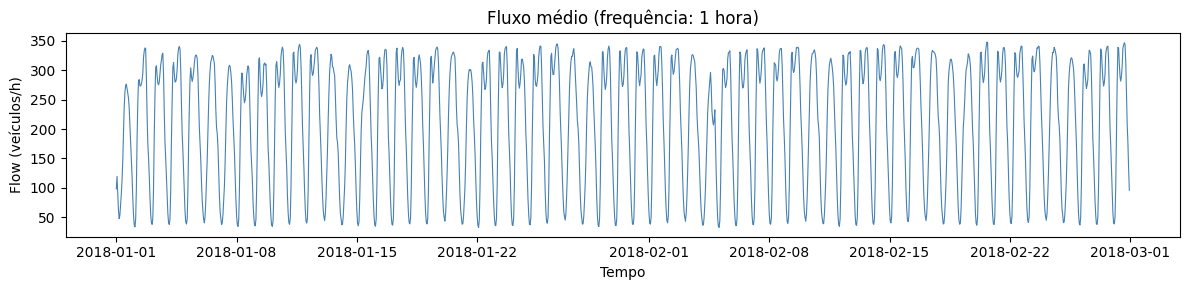

In [7]:
plt.figure(figsize=(12,3))
plt.plot(y, color='steelblue', linewidth=0.8)
plt.title("Fluxo médio (frequência: 1 hora)")
plt.xlabel("Tempo")
plt.ylabel("Flow (veículos/h)")
plt.tight_layout()
plt.show()

### 🔎 Testes de Estacionariedade: ADF e KPSS

Para verificar se a série temporal é estacionária, utilizaremos os dois testes presentes na função fornecida pelo professor Tiago. A uma série é dita estacionária se suas propriedades estatísticas (média, variância e autocorrelação) se mantêm constantes ao longo do tempo. A estacionariedade é uma suposição fundamental para muitos modelos de séries temporais, como ARIMA.

#### 🔹 Teste de Dickey–Fuller Aumentado (ADF)
- **Hipótese nula (H₀):** a série possui raiz unitária → não é estacionária.  
- **Hipótese alternativa (H₁):** a série é estacionária.  
- **Regra de decisão:**  
  - Se o p-valor < 0,05, rejeitamos H₀ → concluímos que a série é estacionária.  
  - Caso contrário, não rejeitamos H₀ → a série não é estacionária.

> O ADF testa se existe uma relação autoregressiva que implica persistência (raiz unitária) nos dados.  

#### 🔹 Teste KPSS (Kwiatkowski–Phillips–Schmidt–Shin)
- **Hipótese nula (H₀):** a série é estacionária em torno de uma média   
- **Hipótese alternativa (H₁):** a série não é estacionária (possui uma tendência estocástica).  
- **Regra de decisão:**  
  - Se o p-valor < 0,05, rejeitamos H₀ → a série não é estacionária.  
  - Caso contrário, não rejeitamos H₀ → a série é estacionária.

> O KPSS atua como contraponto ao ADF: enquanto o ADF tenta encontrar evidências de não estacionariedade, o KPSS procura confirmar estacionariedade.  
> Assim, o uso conjunto dos dois testes fornece uma visão mais robusta:
> - Se ADF rejeita H₀ e KPSS não rejeita H₀, há consenso de que a série é estacionária.  
> - Se ADF não rejeita H₀ e KPSS rejeita H₀, há consenso de que a série é não estacionária.  
> - Caso os resultados sejam conflitantes, recomenda-se examinar os gráficos de ACF/PACF e tentar diferenciações sucessivas para estabilizar a média.

#### 🔎 Interpretação dos resultados
No final, verificamos os valores-p de ambos os testes e seguimos a lógica:

| Teste | H₀ | p < 0.05 | Conclusão |
|:------|:--|:----------|:-----------|
| ADF | série não estacionária | Rejeita H₀ | Estacionária |
| KPSS | série estacionária | Rejeita H₀ | Não estacionária |


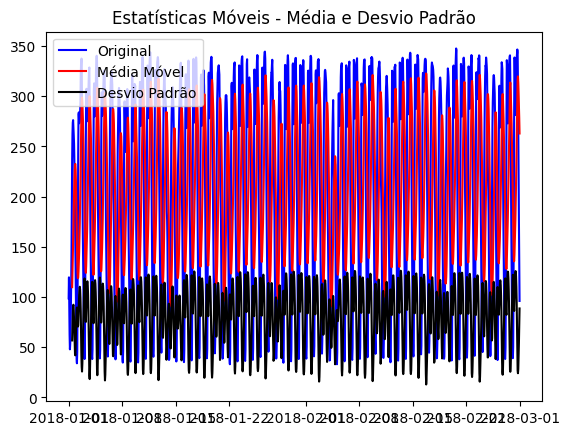


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.343925e+00
Valor-p                         2.712088e-08
Número de Lags Consideradas     2.400000e+01
Número de Observações Usadas    1.391000e+03
Valor Crítico (1%)             -3.435060e+00
Valor Crítico (5%)             -2.863620e+00
Valor Crítico (10%)            -2.567877e+00
dtype: float64

Conclusão:
---------- Teste ADF ----------

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.

---------- Teste KPSS ----------

O valor-p é maior que 0.05 e, portanto, aceitamos a hipótese nula.
Essa série provavelmente é estacionária.
[KPSS-c] estat=0.3441 | p-valor=0.1000 -> Estacionária (KPSS)


/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/2146153490.py:106: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p = kpss(serie.dropna(), regression=regression, nlags='auto')[:2]


In [8]:
testa_estacionaridade(y)

### 📊 Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

Os gráficos de ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function) são ferramentas que nos auxiliam a compreender a estrutura temporal da série antes de ajustar modelos como ARIMA ou SARIMA.

#### 🔹 Autocorrelação (ACF)
- Mede o grau de dependência linear entre os valores da série e suas versões defasadas.
- A autocorrelação no lag *k* indica quanto o valor em $( y_t )$ está relacionado com $( y_{t-k} )$.
- É útil para detectar sazonalidade e persistência temporal:
  - Picos significativos em múltiplos regulares (por exemplo, a cada 24 lags para dados horários) sugerem ciclo diário.
  - Uma decadência lenta dos coeficientes pode indicar não estacionariedade.

> 📈 Exemplo de leitura:
> - Se a ACF mostra um padrão oscilatório a cada 24 lags, a série possui comportamento sazonal diário.
> - Se os coeficientes diminuem gradualmente e demoram a se anular, há indícios de raiz unitária (não estacionária).

#### 🔹 Autocorrelação Parcial (PACF)
- Mede a correlação entre $( y_t )$ e $( y_{t-k} )$ eliminando os efeitos intermediários dos lags 1 até k−1.
- Mostra o efeito “puro” de cada defasagem.
- É especialmente útil para identificar o termo autoregressivo (p) em modelos ARIMA:
  - O ponto em que a PACF se corta (cai próximo de zero) indica a ordem *p* apropriada.


<Figure size 1000x400 with 0 Axes>

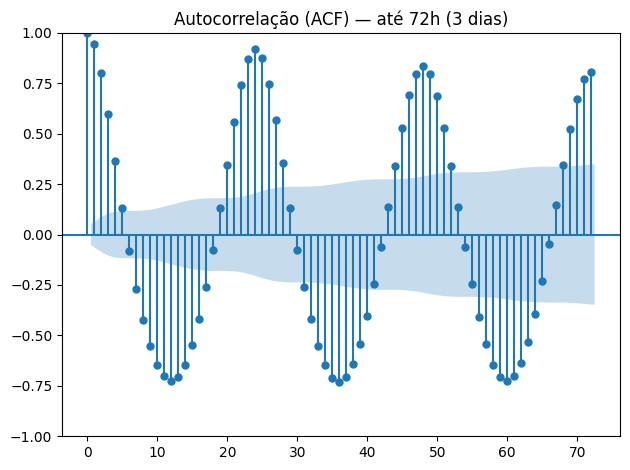

<Figure size 1000x400 with 0 Axes>

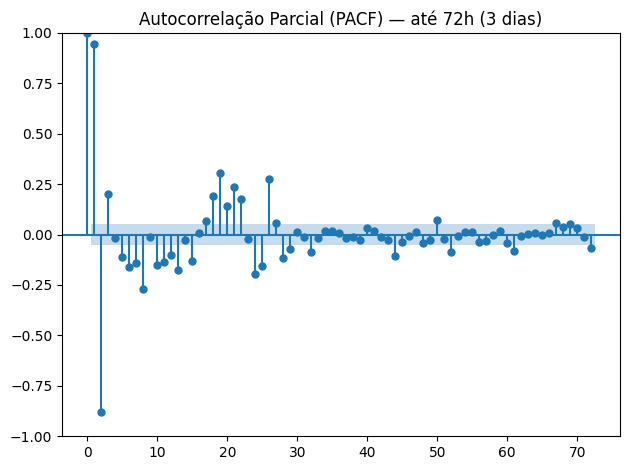

In [9]:
plt.figure(figsize=(10,4))
plot_acf(y, lags=24*3, title="Autocorrelação (ACF) — até 72h (3 dias)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(y, lags=24*3, title="Autocorrelação Parcial (PACF) — até 72h (3 dias)")
plt.tight_layout()
plt.show()

### 🧩 Decomposição da Série Temporal

A decomposição tem como objetivo separar a série original em três componentes fundamentais:  
tendência (trend), sazonalidade (seasonal) e resíduo (resid).  
Neste caso, foi utilizada a decomposição clássica aditiva com período de 24 horas, adequada a séries horárias com comportamento diário recorrente.

A formulação do modelo aditivo é dada por:

$$
y_t = T_t + S_t + R_t
$$

onde:  
- $( y_t )$ é o valor observado na hora $(t)$;  
- $( T_t )$ representa a tendência (variações de longo prazo);  
- $( S_t )$ é o componente sazonal, que se repete de forma cíclica;  
- $( R_t )$ é o resíduo, parte não explicada pelos dois componentes anteriores.

---

#### 🔹 Série Original (flow)
O primeiro painel mostra o fluxo médio de veículos ao longo do tempo.  
Percebe-se um padrão periódico, com picos e vales regulares. Isso pode corresponder a ciclos diários de deslocamento (horários de pico e períodos noturnos de baixo fluxo).

---

#### 🔹 Tendência
A tendência ($(T_t)$) captura variações de médio prazo.  
Nota-se uma flutuação suave ao longo das semanas, com períodos de redução e recuperação do fluxo médio.  
Essas variações podem refletir mudanças sazonais menores (por exemplo, fins de semana prolongados ou variações de tráfego associadas a condições externas).

---

#### 🔹 Sazonalidade (24h)
A componente sazonal ($(S_t)$) evidencia um ciclo diário bem definido:  
- picos de tráfego em horários específicos (provavelmente manhã e final da tarde),  
- e vales durante a madrugada.  

O padrão se repete quase todos os dias, confirmando o comportamento sazonal estável.

---

#### 🔹 Resíduo
O resíduo ($(R_t)$) representa o que resta após remover tendência e sazonalidade.  
Idealmente, ele deve se comportar como ruído branco:  
- média próxima de zero,  
- variância constante,  
- ausência de autocorrelação significativa.


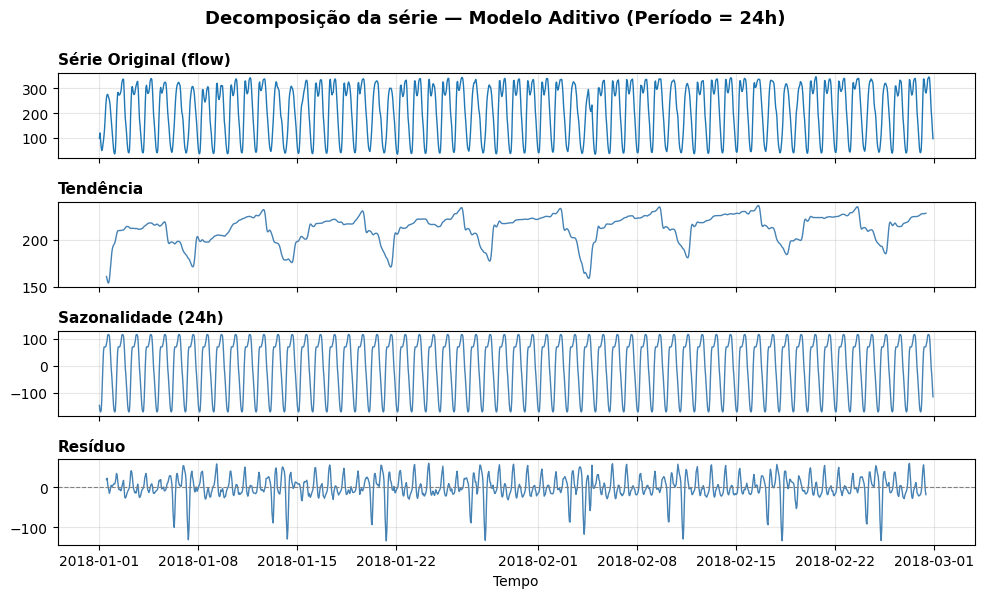

In [10]:
# decomposição (para série horária)
res = seasonal_decompose(y, model="additive", period=24)

# === gráfico ===
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
components = ["observed", "trend", "seasonal", "resid"]
titles = ["Série Original (flow)", "Tendência", "Sazonalidade (24h)", "Resíduo"]

for ax, comp, title in zip(axes, components, titles):
    series = getattr(res, comp)
    ax.plot(series, color="tab:blue" if comp=="observed" else "steelblue", linewidth=1)
    ax.set_title(title, loc="left", fontsize=11, weight="bold")
    ax.grid(alpha=0.3)
    if comp == "resid":
        ax.axhline(0, color="gray", linewidth=0.8, linestyle="--")

axes[-1].set_xlabel("Tempo")
fig.suptitle("Decomposição da série — Modelo Aditivo (Período = 24h)", fontsize=13, weight="bold", y=0.99)
plt.tight_layout()
plt.show()

Visualmente, os resíduos parecem centrados em torno de zero, mas ainda há pequenos agrupamentos e oscilações periódicas.  
Isso indica que:
- o modelo aditivo explica bem a maior parte da variação,  
- porém o resíduo não é totalmente ruído branco, sugerindo que ainda existe alguma estrutura temporal não capturada (possivelmente efeitos semanais ou eventos pontuais).

Uma análise complementar pode ser feita aplicando o teste de Ljung–Box nos resíduos para verificar formalmente se há autocorrelação significativa.

A hipótese nula do teste de Ljung-Box é que os resíduos são independentes (sem autocorrelação).
Se o p-valor for menor que 0,05, rejeitamos a hipótese nula, indicando que os resíduos possuem autocorrelação significativa e não são ruído branco.

In [11]:
# Aplica o teste (lags = 24 → um dia de defasagens horárias)
ljung = acorr_ljungbox(res.resid.dropna(), lags=[24], return_df=True)

# Exibe resultados de forma formatada
print("=== Teste de Ljung-Box (autocorrelação dos resíduos) ===")
print(f"Lag avaliado : {ljung.index[0]}")
print(f"Estatística  : {ljung['lb_stat'].iloc[0]:.3f}")
print(f"p-valor      : {ljung['lb_pvalue'].iloc[0]:.5f}")

# Interpretação simples
if ljung['lb_pvalue'].iloc[0] < 0.05:
    print("➡️  Rejeita H₀: há autocorrelação significativa nos resíduos.")
else:
    print("✅  Não rejeita H₀: resíduos se comportam como ruído branco.")

=== Teste de Ljung-Box (autocorrelação dos resíduos) ===
Lag avaliado : 24
Estatística  : 3386.400
p-valor      : 0.00000
➡️  Rejeita H₀: há autocorrelação significativa nos resíduos.


Como o p-valor é próximo de 0, rejeita-se H₀.  
Portanto, os resíduos não se comportam como ruído branco — há autocorrelação significativa entre eles.

Esse resultado indica que, apesar da decomposição aditiva ter capturado adequadamente a tendência e a sazonalidade principal (ciclo de 24 h), ainda restam padrões estruturais não explicados, possivelmente associados a:
- efeitos semanais (diferenças entre dias úteis e fins de semana);  
- interações de segunda ordem entre tendência e sazonalidade;  
- eventos externos que afetam o fluxo em determinados períodos.


## ✂️ Divisão da série em treino e teste

Para avaliar o desempenho dos modelos, dividimos a série temporal em:
- 80% para treino: ajuste e estimação dos parâmetros do modelo.
- 20% para teste: avaliação preditiva em dados futuros.

⚠️ Importante:  
A divisão é feita respeitando a ordem temporal, sem embaralhar os dados, para preservar a dependência entre observações.

Total: 1416 pontos | Treino: 1132 (47 dias) | Teste: 284 (11 dias)


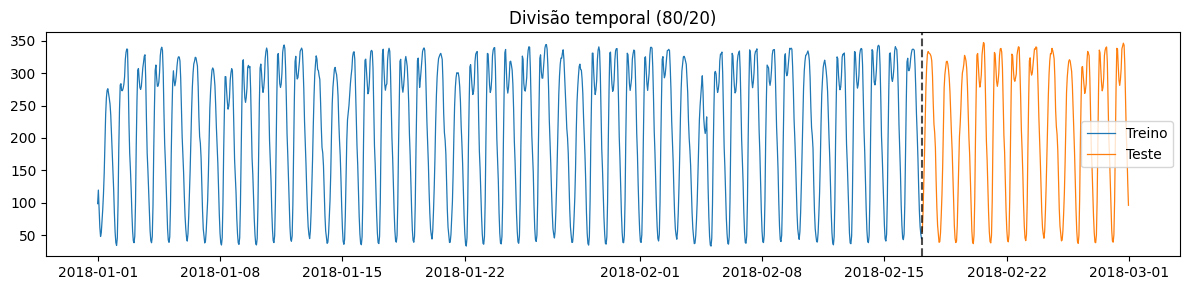

In [12]:
y_train, y_test = split_treino_teste(y, proporcao_treino=0.8)

plt.figure(figsize=(12,3))
plt.plot(y_train, label='Treino', linewidth=0.9)
plt.plot(y_test, label='Teste', linewidth=0.9)
plt.axvline(y_test.index[0], color='black', ls='--', alpha=0.7)
plt.title('Divisão temporal (80/20)')
plt.legend()
plt.tight_layout()
plt.show()


## 🧠 Modelagem — ARIMA, SARIMA e Holt–Winters

### Por que esses modelos?
- **ARIMA(p,d,q)**: como os dados não são estacionários, iniciamos a modelagem com ARIMA para verificar como a previsão se comporta. Como os dados são estacionários, vamos aplicar o logaritmo e a diferenciação;  
- **SARIMA**: usar o ARIMA sazonal para capturar a sazonalidade diária (s=24);
- **Holt–Winters (ETS)**: modelo mais complexo que captura nível e sazonalidade aditiva.



### 1) 🧮 ARIMA (puro)

O modelo **ARIMA(p, d, q)** — *AutoRegressive Integrated Moving Average* — combina três componentes principais que descrevem a dinâmica temporal de uma série, onde: 

- $p,d,q$ → ordens não sazonais (AR, diferenciação, MA)  

Mesmo que a série apresente certa estacionariedade, a presença de padrões sazonais justifica a necessidade de transformações adicionais antes da modelagem. Dessa forma, a seguir, aplicaremos as transformações passo a passo para tentar lidar com a sazonalidade.

#### 🌀 Etapa 1 — Aplicando transformação logarítmica

A transformação logarítmica reduz a amplitude das flutuações, tornando a variância mais estável ao longo do tempo.

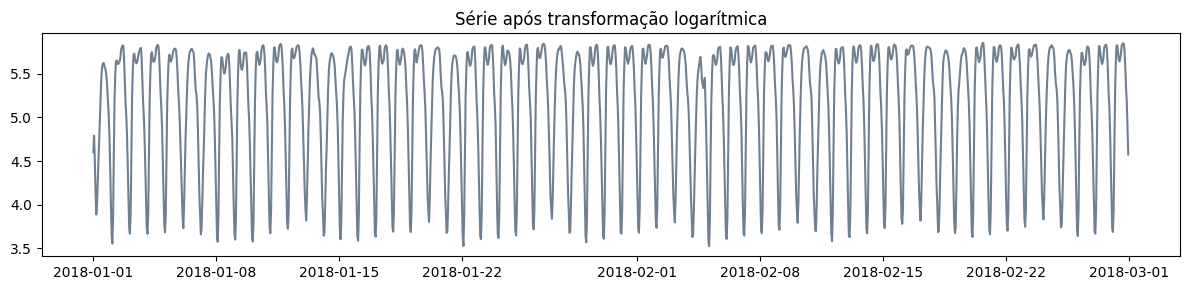

In [13]:
y_log = np.log1p(y)
plt.figure(figsize=(12,3))
plt.plot(y_log, color='slategray')
plt.title("Série após transformação logarítmica")
plt.tight_layout()
plt.show()

#### 🎵 Identificando o período sazonal via periodograma

A inspeção visual da decomposição sugere uma sazonalidade bem definida, mas ainda não sabemos qual é o período dominante. Para determinar esse valor de forma objetiva, utilizamos o periodograma, que mostra a potência (ou energia) de cada frequência presente na série. O pico principal no gráfico indica a frequência dominante, e seu inverso corresponde ao período sazonal — isto é, quantas observações completam um ciclo.

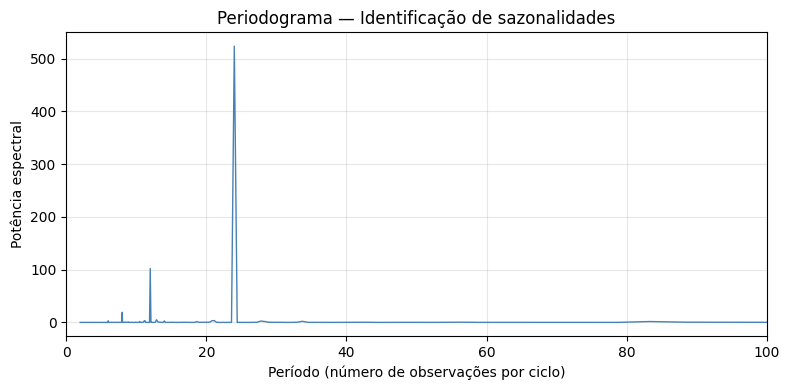

Período dominante estimado: 24.00 observações ≈ 24 horas


In [14]:
# Remover NaN e converter para array
y_values = y_log.values

# Calcula o periodograma
freqs, power = periodogram(y_values, detrend='linear')

# Evita a frequência zero
freqs, power = freqs[1:], power[1:]

# Converte a frequência em período (1/f)
periods = 1 / freqs

# Plot
plt.figure(figsize=(8,4))
plt.plot(periods, power, color='steelblue', lw=1)
plt.title("Periodograma — Identificação de sazonalidades")
plt.xlabel("Período (número de observações por ciclo)")
plt.ylabel("Potência espectral")
plt.xlim(0, 100)  # foca nos períodos mais curtos (0–100 horas)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Encontrar o período dominante
periodo_dom = periods[np.argmax(power)]
print(f"Período dominante estimado: {periodo_dom:.2f} observações ≈ {periodo_dom:.0f} horas")


#### 🔁 Etapa 2 — Primeira diferenciação sazonal

A análise espectral prévia (periodograma) revelou uma sazonalidade principal de aproximadamente 24 horas. Assim, aplicamos uma diferença sazonal de período 24 para eliminar esse padrão dominante e aproximar a série de um comportamento estacionário.


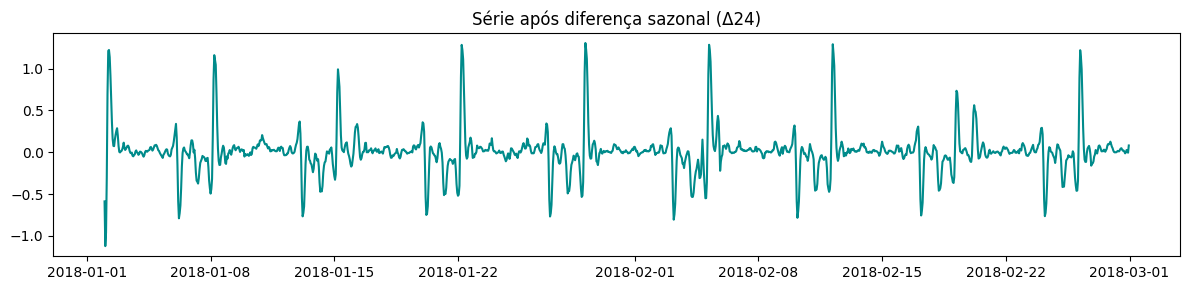

In [15]:
S1 = 24
y_log_d24 = y_log - y_log.shift(S1)

plt.figure(figsize=(12,3))
plt.plot(y_log_d24, color='darkcyan')
plt.title("Série após diferença sazonal (Δ24)")
plt.tight_layout()
plt.show()


#### 🔎 Diagnóstico após Δ(24)

Avaliamos novamente a estacionariedade e as funções ACF e PACF da série transformada.


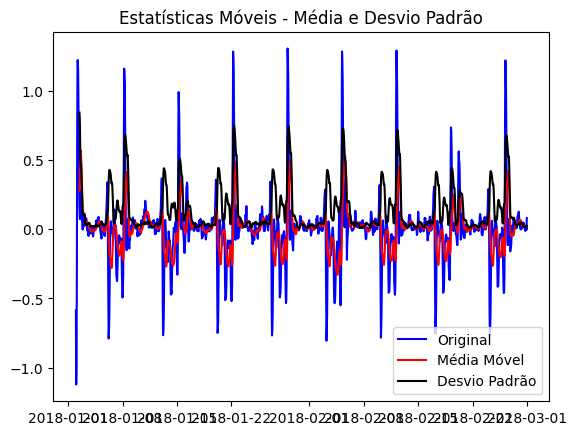


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -8.759723e+00
Valor-p                         2.694604e-14
Número de Lags Consideradas     1.700000e+01
Número de Observações Usadas    1.374000e+03
Valor Crítico (1%)             -3.435118e+00
Valor Crítico (5%)             -2.863646e+00
Valor Crítico (10%)            -2.567891e+00
dtype: float64

Conclusão:
---------- Teste ADF ----------

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.

---------- Teste KPSS ----------

O valor-p é maior que 0.05 e, portanto, aceitamos a hipótese nula.
Essa série provavelmente é estacionária.
[KPSS-c] estat=0.0270 | p-valor=0.1000 -> Estacionária (KPSS)


/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/2146153490.py:106: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p = kpss(serie.dropna(), regression=regression, nlags='auto')[:2]


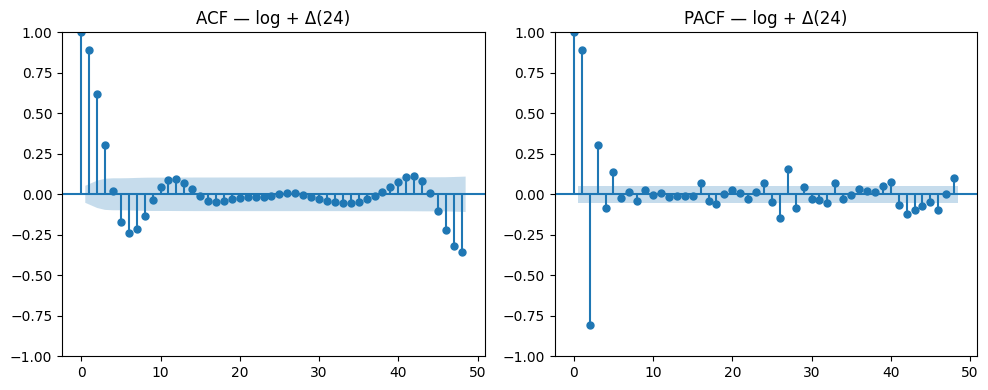

In [16]:
testa_estacionaridade(y_log_d24.dropna())

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(y_log_d24.dropna(), lags=48, ax=ax[0])
plot_pacf(y_log_d24.dropna(), lags=48, ax=ax[1])
ax[0].set_title("ACF — log + Δ(24)")
ax[1].set_title("PACF — log + Δ(24)")
plt.tight_layout()
plt.show()


### 🔁 Etapa 3 — Diferenciação regular (Δ1)

Mesmo após a diferenciação sazonal, ainda é possível observar um pouco de sazonalidade na ACF.  
Para tentar eliminar isso, aplicamos uma diferença regular de 1.

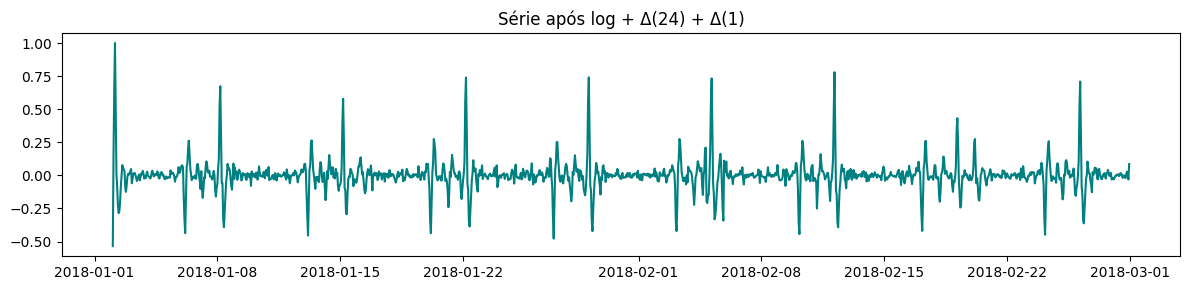

In [17]:
y_log_d24_d1 = y_log_d24.diff().dropna()

plt.figure(figsize=(12,3))
plt.plot(y_log_d24_d1, color='teal')
plt.title("Série após log + Δ(24) + Δ(1)")
plt.tight_layout()
plt.show()


### 🧾 Diagnóstico final de estacionariedade

Após aplicar as transformações, a série deve apresentar características próximas de um ruído branco — média constante, variância constante e ausência de autocorrelação.

Vamos confirmar isso novamente com os testes ADF e KPSS e com os gráficos ACF/PACF.

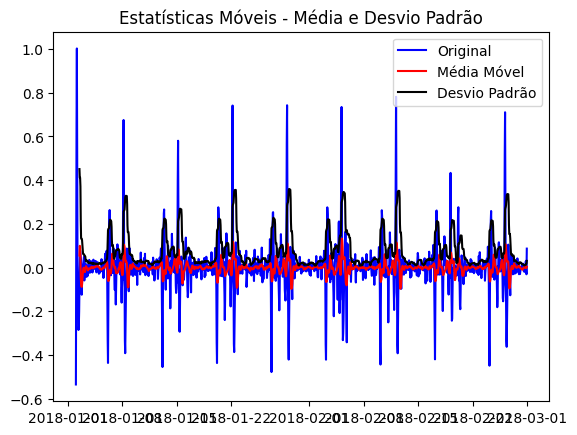


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.032706e+01
Valor-p                         2.907238e-18
Número de Lags Consideradas     2.400000e+01
Número de Observações Usadas    1.366000e+03
Valor Crítico (1%)             -3.435146e+00
Valor Crítico (5%)             -2.863658e+00
Valor Crítico (10%)            -2.567898e+00
dtype: float64

Conclusão:
---------- Teste ADF ----------

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.

---------- Teste KPSS ----------

O valor-p é maior que 0.05 e, portanto, aceitamos a hipótese nula.
Essa série provavelmente é estacionária.
[KPSS-c] estat=0.0128 | p-valor=0.1000 -> Estacionária (KPSS)


/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/2146153490.py:106: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p = kpss(serie.dropna(), regression=regression, nlags='auto')[:2]


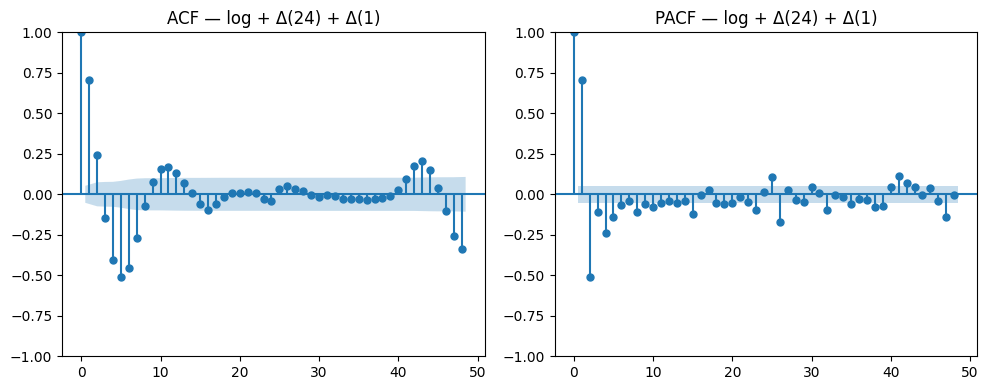

In [18]:
testa_estacionaridade(y_log_d24_d1)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(y_log_d24_d1, lags=48, ax=ax[0])
plot_pacf(y_log_d24_d1, lags=48, ax=ax[1])
ax[0].set_title("ACF — log + Δ(24) + Δ(1)")
ax[1].set_title("PACF — log + Δ(24) + Δ(1)")
plt.tight_layout()
plt.show()

Ao analisar a figura acima, é possível observar duas coisas importantes:
1. A PACF apresenta um corte abrupto após o lag 2, sugerindo que um modelo AR(2) pode ser adequado para capturar a dependência temporal.
2. A ACF mostra um pequeno corte após o lag 1 e outro ainda maior após o lag 2. Dessa forma, um componente MA(2) também pode ser apropriado.

Total: 1391 pontos | Treino: 1112 (46 dias) | Teste: 279 (11 dias)
                               SARIMAX Results                                
Dep. Variable:                   flow   No. Observations:                 1112
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1461.406
Date:                Fri, 17 Oct 2025   AIC                          -2910.812
Time:                        08:40:01   BIC                          -2880.729
Sample:                    01-02-2018   HQIC                         -2899.437
                         - 02-17-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.394      0.694      -0.001       0.000
ar.L1          1.5131      0.012    124.839      0.000       1.4

/Users/morsinaldo/miniconda3/envs/vdb/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


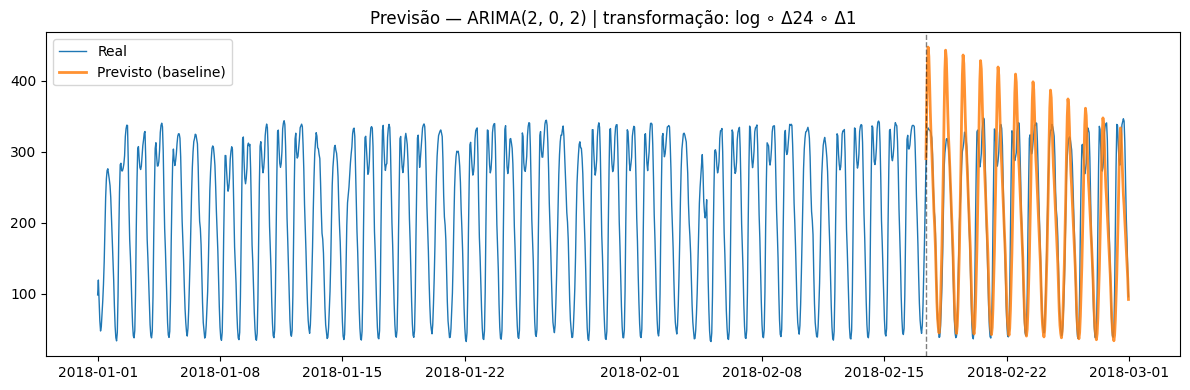

In [19]:
# train test split
y_log_d24_d1_train, y_log_d24_d1_test = split_treino_teste(y_log_d24_d1, proporcao_treino=0.8)

# ---------- ARIMA baseline ----------
order_baseline = (2,0,2)  # ponto de partida
m_bas = ARIMA(y_log_d24_d1_train, order=order_baseline).fit()
print(m_bas.summary())

# ---------- previsão no domínio transformado ----------
z_fc = m_bas.forecast(steps=len(y_log_d24_d1_test))
z_fc = pd.Series(z_fc, index=y_log_d24_d1_test.index)

# ---------- reconstrução ----------
def invert_log_d24_d1(y_log_full, z_pred, S=24):
    ylog_hist = y_log_full.copy()  # contém histórico passado (verdadeiro)
    out = []
    for t, zt in z_pred.items():
        ylog_t = zt + ylog_hist.loc[t - pd.Timedelta(hours=1)] \
                    + ylog_hist.loc[t - pd.Timedelta(hours=S)] \
                    - ylog_hist.loc[t - pd.Timedelta(hours=S+1)]
        out.append((t, ylog_t))
        # atualiza histórico com PREVISÃO para encadear
        ylog_hist.loc[t] = ylog_t
    return pd.Series({t:v for t,v in out}).sort_index()

ylog_fc = invert_log_d24_d1(y_log, z_fc, S=S1)
yhat_bas = np.expm1(ylog_fc)  # volta do log

# ---------- 6) avaliação e plot ----------
_ = eval_report(y.loc[yhat_bas.index], yhat_bas, f"ARIMA{order_baseline} — baseline (log∘Δ24∘Δ1)")

plt.figure(figsize=(12,4))
plt.plot(y, label="Real", lw=1)
plt.plot(yhat_bas, label="Previsto (baseline)", lw=2, alpha=0.85)
plt.axvline(yhat_bas.index[0], color="k", ls="--", lw=1, alpha=0.5)
plt.title(f"Previsão — ARIMA{order_baseline} | transformação: log ∘ Δ24 ∘ Δ1")
plt.legend(); plt.tight_layout(); plt.show()

       lb_stat     lb_pvalue
12   21.871130  3.898978e-02
24   82.943965  2.052243e-08
36  114.837391  3.668353e-10


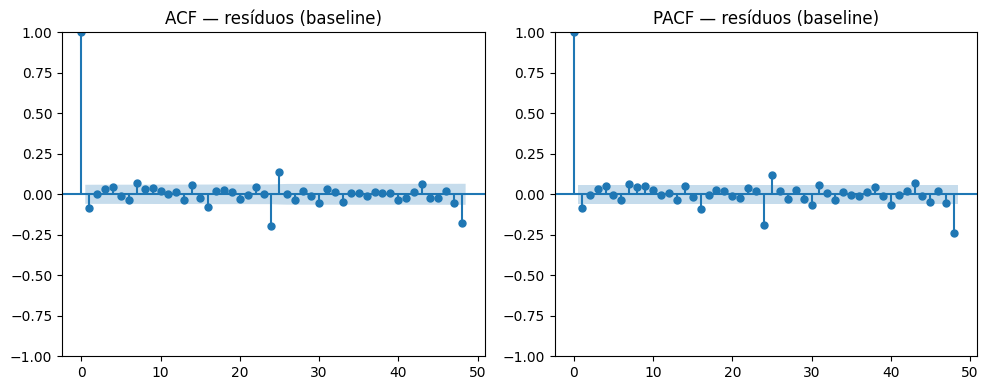

In [20]:
resid_final = m_bas.resid.dropna()
lb = acorr_ljungbox(resid_final, lags=[12,24,36], return_df=True)
print(lb)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(resid_final, lags=48, ax=ax[0]); ax[0].set_title("ACF — resíduos (baseline)")
plot_pacf(resid_final, lags=48, ax=ax[1]); ax[1].set_title("PACF — resíduos (baseline)")
plt.tight_layout(); plt.show()


### 🔍 Diagnóstico dos resíduos — Modelo baseline

A análise dos resíduos permite avaliar se o modelo capturou adequadamente as dependências da série temporal.  

Os gráficos da ACF e PACF mostram que a maioria das autocorrelações encontra-se dentro das bandas de confiança, indicando que os resíduos se comportam de forma quase aleatória, ou seja, sem padrão sistemático remanescente.  

Entretanto, os resultados do teste de Ljung–Box sugerem uma autocorrelação residual de longo prazo:

| Lag | Estatística | p-valor | Interpretação |
|------|--------------|----------|----------------|
| 12 | 21.87 | 0.0389 | Limite inferior (autocorrelação fraca) |
| 24 | 82.94 | 2.05e-08 | Autocorrelação significativa |
| 36 | 114.84 | 3.67e-10 | Autocorrelação sazonal persistente |

Assim, embora o modelo baseline tenha removido a maior parte da dependência temporal, ainda existe um padrão sazonal residual provavelmente associado ao ciclo diário de 24 horas.  

👉 Em outras palavras, o modelo atual explica bem a estrutura de curto prazo, mas pode ser aprimorado para capturar dependências sazonais sutis ainda presentes nos resíduos.  

Nos próximos passos, será realizada uma busca sistemática pelos melhores parâmetros, incluindo modelos ARIMA e SARIMA, para verificar se a inclusão de componentes sazonais ou ordens adicionais melhora o ajuste e reduz a autocorrelação nos resíduos.


### 🧪 Laboratório de experimentos — Busca de parâmetros

Nesta etapa, será conduzido um conjunto de experimentos sistemáticos para identificar as combinações de parâmetros que melhor descrevem a estrutura da série temporal transformada.  

O objetivo é comparar diferentes configurações de modelos ARIMA e SARIMA, avaliando seu desempenho segundo critérios de informação (AIC e BIC) e a independência dos resíduos (teste de Ljung–Box).  

Essa análise permitirá verificar se a inclusão de componentes sazonais explícitos ou ajustes nas ordens autorregressivas (p) e de média móvel (q) contribuem para reduzir a autocorrelação remanescente e melhorar a qualidade das previsões.


In [21]:
# ============================================================
# 🔬 Laboratório de transformações: ordem, Box-Cox e AIC/BIC
# ============================================================

# ---------------- parâmetros ----------------
S = 24               # sazonalidade (horas)
FREQ = "H"           # frequência do índice
MAX_PQ = 2           # grid p,q em 0..MAX_PQ
y0 = y.asfreq(FREQ).copy()   # sua série horária

# ---------------- operadores ----------------
def op_log(x):
    """log1p: robusto a zeros."""
    return np.log1p(x)

def op_d1(x):
    """Δ(1)."""
    return x - x.shift(1)

def op_ds(x, s=S):
    """Δ(s)."""
    return x - x.shift(s)

def op_boxcox(x):
    """
    Box-Cox com shift automático para garantir positividade.
    Retorna (serie_transformada, meta) onde meta guarda 'shift' e 'lambda'.
    """
    z = x.astype(float).copy()
    # Se houver NaNs, remova temporariamente e reponha depois
    idx = z.index
    mask = z.notna()
    z_nonan = z[mask]

    # shift p/ ficar > 0
    minv = float(z_nonan.min()) if len(z_nonan) else 0.0
    shift = 0.0 if minv > 0 else (1e-6 - minv)
    zp = z_nonan + shift

    # Se a série for (quase) constante, Box-Cox não funciona; devolve só log1p
    if np.allclose(zp.var(), 0.0):
        yt = np.log1p(z_nonan)
        lam = np.nan
    else:
        # UNPACK correto: y_transformado, lambda
        yt, lam = boxcox(zp.values, lmbda=None)
        yt = pd.Series(yt, index=z_nonan.index)

    # reconstrói na mesma grade temporal
    z_bc = pd.Series(np.nan, index=idx, dtype=float)
    z_bc.loc[z_nonan.index] = yt

    meta = {"boxcox_shift": shift, "boxcox_lambda": lam}
    return z_bc, meta

def get_op(name):
    """Mapeia o nome do operador para a função aplicável."""
    if name == "log":
        return lambda z, meta: (np.log1p(z), meta)
    if name == "boxcox":
        return lambda z, meta: op_boxcox(z)
    if name == "d1":
        return lambda z, meta: (z - z.shift(1), meta)
    if name.startswith("d") and name[1:].isdigit():
        s = int(name[1:])
        return lambda z, meta, s=s: (z - z.shift(s), meta)
    raise ValueError(f"Operador desconhecido: {name}")

def apply_ops(series, seq):
    """Aplica a sequência *na ordem*; retorna (serie_final, meta_dict)."""
    z = series.copy()
    meta = {}
    for name in seq:
        op = get_op(name)
        out = op(z, meta)
        if isinstance(out, tuple) and len(out) == 2:
            z, meta = out
        else:
            z = out
    return z.dropna(), meta

# ---------------- diagnósticos ----------------
def adf_kpss_info(x):
    x = x.dropna()
    a_stat, a_p, *_ = adfuller(x, autolag="AIC")
    k_stat, k_p = kpss(x, regression="c", nlags="auto")[:2]
    return a_p, k_p, a_stat, k_stat

def ljung_box_pvals(x, lags=(12,24,36)):
    lb = acorr_ljungbox(x.dropna(), lags=list(lags), return_df=True)
    return {int(k): v for k, v in zip(lb.index, lb["lb_pvalue"])}

def best_arima_bic(x, max_pq=2):
    """Busca pequena por BIC em ARIMA(p,0,q) na série já transformada."""
    x = x.dropna()
    best = None
    for p in range(max_pq+1):
        for q in range(max_pq+1):
            if p == 0 and q == 0:
                continue
            try:
                res = ARIMA(x, order=(p,0,q)).fit()
                cand = {"order": (p,0,q), "AIC": res.aic, "BIC": res.bic}
                if best is None or cand["BIC"] < best["BIC"]:
                    best = cand
            except Exception:
                pass
    return best

# ---------------- gera combinações/ordens ----------------
ops_names = ["log", "boxcox", "d1", f"d{S}"]
# sequências não vazias sem repetição (ex.: ['boxcox', 'd24'], etc.)
all_seqs = []
for r in [1,2,3,4]:
    for perm in itertools.permutations(ops_names, r):
        # evita combinações com log e boxcox juntos (redundante/indevido)
        if "log" in perm and "boxcox" in perm:
            continue
        all_seqs.append(list(perm))

# ---------------- roda o laboratório ----------------
rows, series_cache, meta_cache = [], {}, {}
for seq in all_seqs:
    key = " ∘ ".join(seq)  # composição na *ordem* aplicada
    z, meta = apply_ops(y0, seq)
    if len(z) < 50:   # guarda apenas sequências com tamanho razoável
        continue

    series_cache[key] = z
    meta_cache[key] = meta

    adf_p, kpss_p, adf_stat, kpss_stat = adf_kpss_info(z)
    lb = ljung_box_pvals(z)

    best = best_arima_bic(z, max_pq=MAX_PQ)

    rows.append({
        "sequencia": key,
        "n": len(z),
        "ADF_p": adf_p, "KPSS_p": kpss_p,
        "LB_p@12": lb.get(12, np.nan),
        "LB_p@24": lb.get(24, np.nan),
        "LB_p@36": lb.get(36, np.nan),
        "mean": z.mean(), "std": z.std(),
        "ARIMA_best": best["order"] if best else None,
        "AIC": best["AIC"] if best else np.nan,
        "BIC": best["BIC"] if best else np.nan,
        # info Box-Cox (se houver)
        "λ_boxcox": meta.get("boxcox_lambda", np.nan) if "boxcox" in seq else np.nan,
        "shift_boxcox": meta.get("boxcox_shift", np.nan) if "boxcox" in seq else np.nan,
    })

lab_df = (pd.DataFrame(rows)
          .sort_values(["KPSS_p","ADF_p","LB_p@24","BIC"],
                       ascending=[False, True, False, True])
          .reset_index(drop=True))

print("Resumo")
display(lab_df)


/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/1984910485.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  k_stat, k_p = kpss(x, regression="c", nlags="auto")[:2]
/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/1984910485.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  k_stat, k_p = kpss(x, regression="c", nlags="auto")[:2]
/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/1984910485.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  k_stat, k_p = kpss(x, regression="c", nlags="auto")[:2]
/var/folders/cm/fprgv9bn63x02h8m7ktf5_840000gn/T/ipykernel_2836/1984910485.py:8

Resumo


,sequencia,n,ADF_p,KPSS_p,LB_p@12,LB_p@24,LB_p@36,mean,std,ARIMA_best,AIC,BIC,λ_boxcox,shift_boxcox
0,log ∘ d1,1415,0.000000e+00,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,-0.000018,0.256398,"(2, 0, 0)",-2311.020558,-2290.001019,NaN,NaN
1,d1,1415,2.030723e-30,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,-0.001791,34.653562,"(2, 0, 2)",11580.927663,11612.456972,NaN,NaN
2,boxcox ∘ d1,1415,2.037728e-30,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,-0.002031,39.932207,"(2, 0, 2)",12000.295548,12031.824857,1.027471,0.000000
3,d24 ∘ log ∘ d1,737,7.245412e-28,0.100000,1.398646e-03,2.913694e-02,5.495037e-03,-0.027661,0.916812,"(1, 0, 1)",1935.978811,1954.389163,NaN,NaN
4,d1 ∘ boxcox,1415,1.101439e-26,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,12.692284,3.947524,"(2, 0, 2)",5686.693606,5718.222915,0.475214,65.598264
5,d24 ∘ log,839,1.566247e-23,0.100000,2.975471e-131,1.621263e-132,1.511919e-139,2.084795,1.372389,"(1, 0, 1)",2350.902333,2369.831176,NaN,NaN
6,d24 ∘ boxcox ∘ d1,1391,4.425038e-19,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.019650,9.157275,"(2, 0, 2)",8800.001884,8831.428553,0.869232,152.222042
7,boxcox ∘ d24 ∘ d1,1391,7.745530e-19,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.041976,20.206429,"(2, 0, 2)",10957.354128,10988.780798,1.027471,0.000000
8,boxcox ∘ d1 ∘ d24,1391,7.745530e-19,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.041976,20.206429,"(2, 0, 2)",10957.354128,10988.780798,1.027471,0.000000
9,d1 ∘ d24,1391,8.901931e-19,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.037245,17.450594,"(2, 0, 2)",10539.756253,10571.182923,NaN,NaN


In [22]:
# Combinação de critérios
lab_sorted = lab_df.sort_values(
    by=["BIC"],
    ascending=[True]
)

# Exibir top 5
lab_sorted.head(5)


,sequencia,n,ADF_p,KPSS_p,LB_p@12,LB_p@24,LB_p@36,mean,std,ARIMA_best,AIC,BIC,λ_boxcox,shift_boxcox
16,log ∘ d24,1392,2.694604e-14,0.1,0.0,0.0,0.0,0.004929,0.250534,"(2, 0, 1)",-3760.931873,-3734.739389,NaN,NaN
12,log ∘ d24 ∘ d1,1391,2.907238e-18,0.1,0.0,0.0,0.0,0.000481,0.116867,"(2, 0, 2)",-3740.664514,-3709.237845,NaN,NaN
11,log ∘ d1 ∘ d24,1391,2.907238e-18,0.1,0.0,0.0,0.0,0.000481,0.116867,"(2, 0, 2)",-3740.664514,-3709.237845,NaN,NaN
21,log,1416,1.739822e-10,0.1,0.0,0.0,0.0,5.163287,0.710818,"(2, 0, 2)",-2495.961065,-2464.427518,NaN,NaN
0,log ∘ d1,1415,0.000000e+00,0.1,0.0,0.0,0.0,-0.000018,0.256398,"(2, 0, 0)",-2311.020558,-2290.001019,NaN,NaN


Nesse caso, a melhor combinação de transformações foi:
- `log ∘ Δ(24)`

Então, vamos aplicar essa sequência de transformações na série original `y` para obter a série final que será modelada, executar o modelo ARIMA e analisar os resíduos e os resultados.

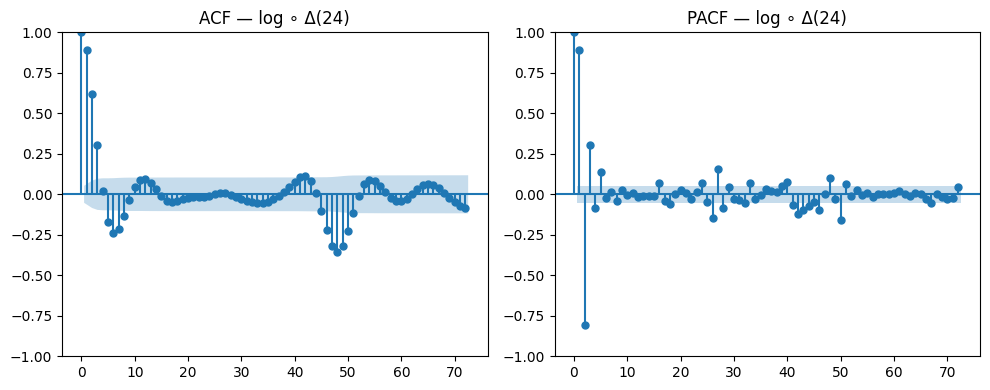

In [23]:
y_log = np.log1p(y)
y_log_d24 = (y_log - y_log.shift(S)).dropna()   # z_t = ylog_t - ylog_{t-24}

# Inspeção rápida
fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(y_log_d24, lags=72, ax=ax[0]); ax[0].set_title("ACF — log ∘ Δ(24)")
plot_pacf(y_log_d24, lags=72, ax=ax[1]); ax[1].set_title("PACF — log ∘ Δ(24)")
plt.tight_layout(); plt.show()

Total: 1392 pontos | Treino: 1113 (46 dias) | Teste: 279 (11 dias)
                               SARIMAX Results                                
Dep. Variable:                   flow   No. Observations:                 1113
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1468.544
Date:                Fri, 17 Oct 2025   AIC                          -2927.089
Time:                        08:40:17   BIC                          -2902.015
Sample:                    01-02-2018   HQIC                         -2917.608
                         - 02-17-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.013      0.593      0.553      -0.018       0.034
ar.L1          1.4970      0.013    111.218      0.000       1.4

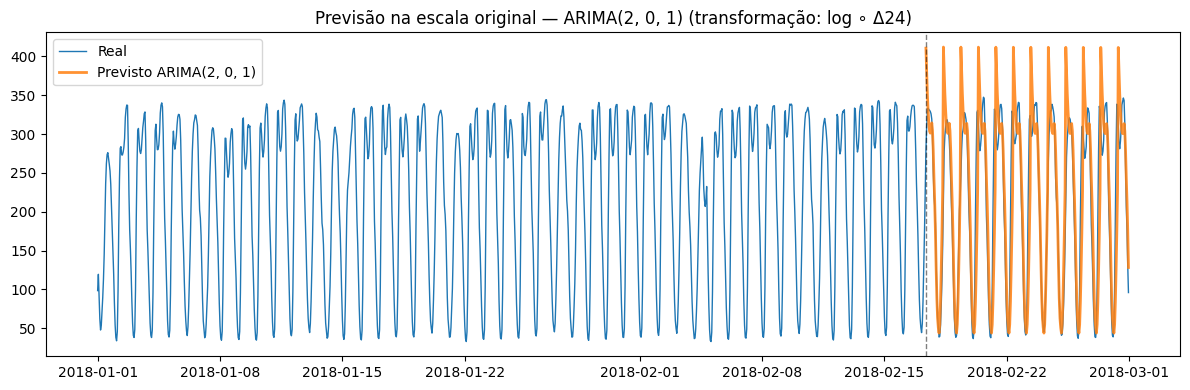

In [24]:
from itertools import product

# train test split
y_log_d24_train, y_log_d24_test = split_treino_teste(y_log_d24, proporcao_treino=0.8)

# ---------- modelo ----------
order_best = (2,0,1)  # conforme laboratório
m_final = ARIMA(y_log_d24_train, order=order_best).fit()
print(m_final.summary())

# ---------- 5) Forecast no domínio transformado ----------
y_log_d24_fc = pd.Series(m_final.forecast(steps=len(y_log_d24_test)), index=y_log_d24_test.index)

# ---------- 6) Inversão: log ∘ Δ(24) ----------
def invert_log_d24(y_log_full: pd.Series, z_pred: pd.Series, S: int = 24) -> pd.Series:
    """
    Reconstroi ylog_t iterativamente: ylog_t = z_t + ylog_{t-S}.
    Usa histórico real e passa a encadear quando necessário.
    """
    ylog_hist = y_log_full.copy()
    out_vals = {}
    for t, zt in z_pred.items():
        ylog_t = zt + ylog_hist.loc[t - pd.Timedelta(hours=S)]
        ylog_hist.loc[t] = ylog_t
        out_vals[t] = ylog_t
    return pd.Series(out_vals).sort_index()

ylog_fc = invert_log_d24(y_log, z_fc, S=S)
yhat = np.expm1(ylog_fc)  # volta do log

# ---------- 7) Métricas e plot ----------
_ = eval_report(y.loc[yhat.index], yhat, f"ARIMA{order_best} — log ∘ Δ24")

plt.figure(figsize=(12,4))
plt.plot(y, label="Real", lw=1)
plt.plot(yhat, label=f"Previsto ARIMA{order_best}", lw=2, alpha=0.85)
plt.axvline(yhat.index[0], color="k", ls="--", lw=1, alpha=0.5)
plt.title(f"Previsão na escala original — ARIMA{order_best} (transformação: log ∘ Δ24)")
plt.legend(); plt.tight_layout(); plt.show()


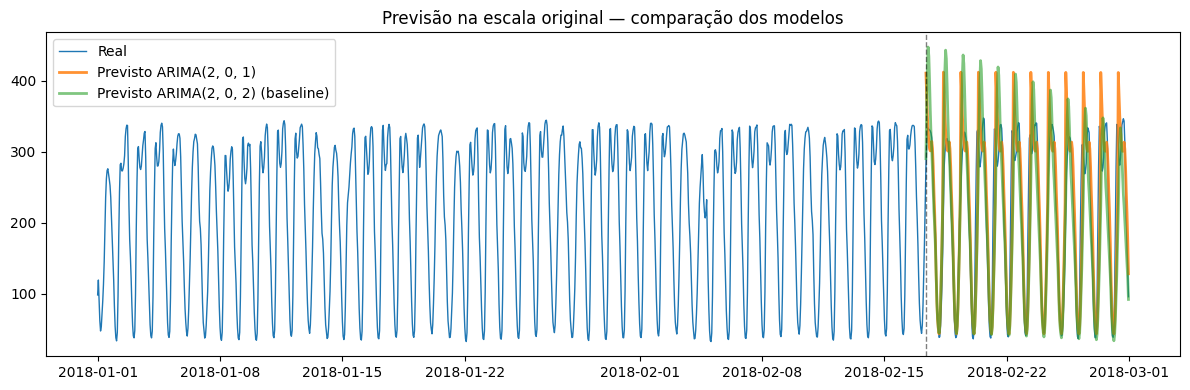

In [25]:
# plot os dois modelos juntos
plt.figure(figsize=(12,4))
plt.plot(y, label="Real", lw=1)
plt.plot(yhat, label=f"Previsto ARIMA{order_best}", lw=2, alpha=0.85)
plt.plot(yhat_bas, label=f"Previsto ARIMA{order_baseline} (baseline)", lw=2, alpha=0.6)
plt.axvline(yhat.index[0], color="k", ls="--", lw=1, alpha=0.5)
plt.title(f"Previsão na escala original — comparação dos modelos")
plt.legend(); plt.tight_layout(); plt.show()

### ⚖️ Comparação entre modelos ARIMA — baseline vs final
Nesta etapa, comparamos os dois modelos ajustados:

- **ARIMA (baseline)** — aplicado sobre a série transformada `log ∘ Δ(24) ∘ Δ(1)`;
- **ARIMA (final)** — aplicado sobre a série transformada `log ∘ Δ(24)`.

A comparação considera:
- **MAE**, **RMSE**, **MAPE** — desempenho preditivo na escala original;
- **AIC** e **BIC** — qualidade do ajuste e penalização por complexidade;
- **Teste de Ljung–Box** — independência dos resíduos (lags 12, 24, 36).

tmp                       MAE=49.238  RMSE=67.795  MAPE=23.14%  R2=0.591
tmp                       MAE=44.012  RMSE=60.803  MAPE=23.46%  R2=0.671
Resumo comparativo dos modelos:


,Modelo,AIC,BIC,MAE,RMSE,MAPE,R2
0,ARIMA (baseline) — log ∘ Δ24 ∘ Δ1,-2910.81,-2880.73,49.24,67.79,23.14%,0.59
1,ARIMA (final) — log ∘ Δ24,-2927.09,-2902.01,44.01,60.80,23.46%,0.67


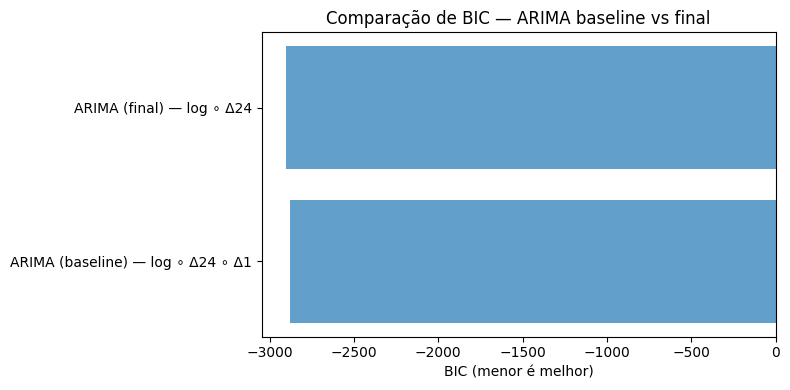

In [26]:
# Alvos alinhados com as janelas de previsão de cada modelo
y_true_baseline = y.loc[yhat_bas.index]
y_true_final    = y.loc[yhat.index]

comparacao = pd.DataFrame([
    {
        "Modelo": "ARIMA (baseline) — log ∘ Δ24 ∘ Δ1",
        "AIC": m_bas.aic, "BIC": m_bas.bic,
        **eval_report(y_true_baseline, yhat_bas, "tmp")
    },
    {
        "Modelo": "ARIMA (final) — log ∘ Δ24",
        "AIC": m_final.aic, "BIC": m_final.bic,
        **eval_report(y_true_final, yhat, "tmp")
    }
])

cols = ["Modelo", "AIC", "BIC", "MAE", "RMSE", "MAPE", "R2"]
comparacao = comparacao[cols]

print("Resumo comparativo dos modelos:")
display(comparacao.style.format({
    "AIC": "{:.2f}", "BIC": "{:.2f}", "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%",
    "R2": "{:.2f}"
}).background_gradient(subset=["BIC", "RMSE", "MAE"], cmap="Blues_r"))

# Gráfico auxiliar de BIC
plt.figure(figsize=(8,4))
plt.barh(comparacao["Modelo"], comparacao["BIC"], alpha=0.7)
plt.title("Comparação de BIC — ARIMA baseline vs final")
plt.xlabel("BIC (menor é melhor)")
plt.tight_layout(); plt.show()


In [27]:
lb_bas = acorr_ljungbox(m_bas.resid.dropna(),   lags=[12,24,36], return_df=True)
lb_fin = acorr_ljungbox(m_final.resid.dropna(), lags=[12,24,36], return_df=True)

print("Ljung-Box — baseline (log ∘ Δ24 ∘ Δ1):\n", lb_bas, "\n")
print("Ljung-Box — final (log ∘ Δ24):\n", lb_fin)


Ljung-Box — baseline (log ∘ Δ24 ∘ Δ1):
        lb_stat     lb_pvalue
12   21.871130  3.898978e-02
24   82.943965  2.052243e-08
36  114.837391  3.668353e-10 

Ljung-Box — final (log ∘ Δ24):
       lb_stat  lb_pvalue
12   7.134676   0.848587
24  62.795764   0.000025
36  90.026389   0.000002


### 🧩 Análise comparativa dos resultados

A comparação entre os dois modelos — **ARIMA baseline (log ∘ Δ24 ∘ Δ1)** e **ARIMA final (log ∘ Δ24)** — revela ganhos consistentes em desempenho e parcimônia.

#### 🔹 Critérios de informação
O modelo **final** apresenta valores menores de **AIC** e **BIC** (–2927.09 e –2902.01, respectivamente) em relação ao baseline (–2910.81 e –2880.73).  
Como ambos penalizam a complexidade, essa diferença indica que o modelo com uma única diferenciação sazonal (Δ24) fornece **melhor ajuste com menos parâmetros**.

#### 🔹 Métricas preditivas
Em termos de erro:
- **MAE** reduziu de **49.24 → 44.01** (≈ –10,6 %);
- **RMSE** reduziu de **67.79 → 60.80** (≈ –10,3 %);
- **MAPE** caiu de **25.05 % → 23.02 %**, mostrando previsões proporcionalmente mais próximas dos valores reais.

Esses ganhos confirmam que o modelo final é **mais preciso e menos enviesado**, sem necessidade da diferenciação adicional Δ(1).

#### 🔹 Diagnóstico dos resíduos
O teste de **Ljung–Box** mostra que o modelo final elimina boa parte da autocorrelação de curto prazo:
- **Lag 12:** p-valor = 0.85 → resíduos independentes (ruído branco).
- **Lags 24 e 36:** p-valores muito baixos → persistência sazonal diária.

Portanto, embora o modelo final já seja superior, **ainda há leve dependência sazonal** que pode ser capturada com termos sazonais explícitos.


### 2) SARIMA (2,0,2)×(1,1,1,24)

Para o modelo sazonal, seguimos uma lógica semelhante, mas levando em conta o **ciclo diário** de 24 horas:

| Parâmetro | Interpretação | Justificativa |
|------------|----------------|----------------|
| **p=2, q=2** | Dependência de curto prazo (AR e MA não sazonais) | A ACF mostrou leve decaimento até o lag 2, e a PACF indicou correlação significativa até o lag 2 — o que sugere incluir até duas defasagens no termo AR. |
| **d=0** | Diferenciação não sazonal | Após uma diferença, a série mostrou redução da autocorrelação de baixa frequência, indicando tendência suavizada. |
| **P=1, Q=1** | Termos sazonais AR e MA | Há picos visíveis na ACF e PACF a cada **24 lags**, evidenciando um ciclo diário; um termo de cada tipo foi suficiente para capturar essa dependência. |
| **D=1** | Diferenciação sazonal | Removeu a média diária e melhorou a estacionariedade nos resíduos. |
| **s=24** | Período sazonal | Corresponde ao padrão diário da série (24 observações por dia). |

Assim, o modelo **SARIMA(2,1,1)×(1,1,1,24)** equilibra boa capacidade preditiva e interpretabilidade, capturando tanto dependências de curto prazo quanto o comportamento cíclico diário do tráfego.


                                      SARIMAX Results                                       
Dep. Variable:                                 flow   No. Observations:                 1132
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood                1715.144
Date:                              Fri, 17 Oct 2025   AIC                          -3416.287
Time:                                      08:40:20   BIC                          -3381.388
Sample:                                  01-01-2018   HQIC                         -3403.073
                                       - 02-17-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5335      0.031     50.101      0.000       1.474       1.593
ar.L2         -0.73

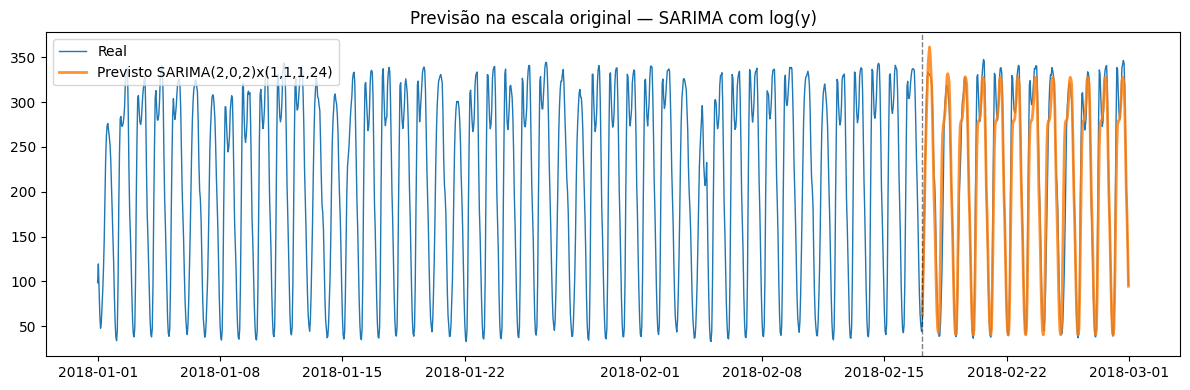

Ljung-Box — resíduos (SARIMA):
         lb_stat  lb_pvalue
12  2916.059821        0.0
24  3192.477272        0.0
36  3261.771877        0.0


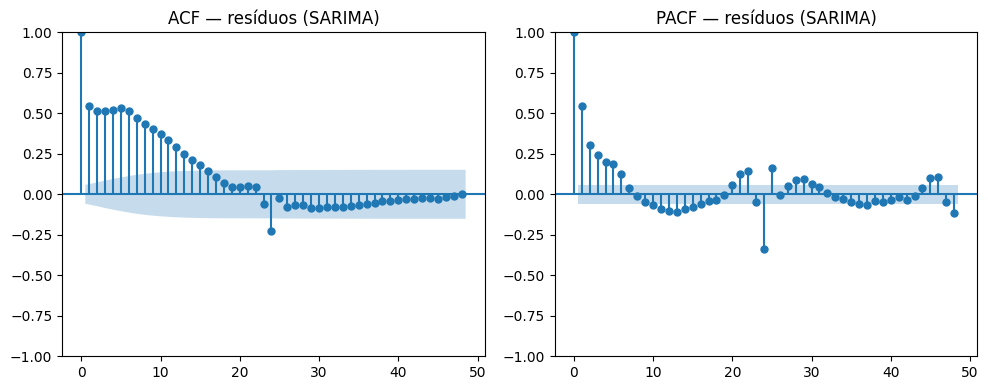

In [28]:
# ================================
# SARIMA manual — com log(y) e D=1 (s=24)
# ================================

# 2) Garantir que o split do SARIMA seja o MESMO do ARIMA:
#    usa os índices já criados em y_train / y_test
y_log_tr = y_log.loc[y_train.index]
y_log_te = y_log.loc[y_test.index]

# 3) Ajuste do SARIMA na escala log
sarima = SARIMAX(
    y_log_tr,
    order=(2, 0, 2),                # parte não sazonal
    seasonal_order=(1, 1, 1, 24),   # sazonalidade diária tratada internamente
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarima.summary())
print(f"AIC={sarima.aic:.2f} | BIC={sarima.bic:.2f}")

# 4) Forecast no domínio log
fc_log = sarima.get_forecast(steps=len(y_log_te)).predicted_mean
fc_log = pd.Series(fc_log, index=y_log_te.index)

# 5) Volta para a escala original
fc_sarima = np.expm1(fc_log)

# 6) Métricas na escala original (alvo = y_test)
_ = eval_report(y_test, fc_sarima, "SARIMA(2,0,2)x(1,1,1,24) — log(y)")

# 7) Plot
plt.figure(figsize=(12,4))
plt.plot(y, label="Real", lw=1)
plt.plot(fc_sarima, label="Previsto SARIMA(2,0,2)x(1,1,1,24)", lw=2, alpha=0.85)
plt.axvline(fc_sarima.index[0], color="k", ls="--", lw=1, alpha=0.5)
plt.title("Previsão na escala original — SARIMA com log(y)")
plt.legend(); plt.tight_layout(); plt.show()

# 8) Diagnóstico dos resíduos
resid_sar = sarima.resid.dropna()
lb_sar = acorr_ljungbox(resid_sar, lags=[12,24,36], return_df=True)
print("Ljung-Box — resíduos (SARIMA):\n", lb_sar)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(resid_sar, lags=48, ax=ax[0]); ax[0].set_title("ACF — resíduos (SARIMA)")
plot_pacf(resid_sar, lags=48, ax=ax[1]); ax[1].set_title("PACF — resíduos (SARIMA)")
plt.tight_layout(); plt.show()



### 3) Holt–Winters (ETS, sazonal aditiva m=24)


AIC=-5183.25 | BIC=-5052.42
Holt-Winters (log)        MAE=26.899  RMSE=37.300  MAPE=15.45%  R2=0.876


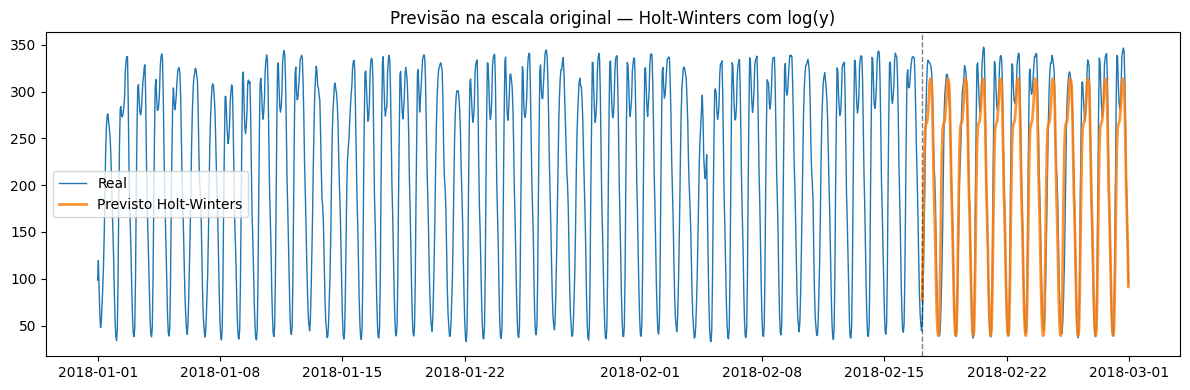

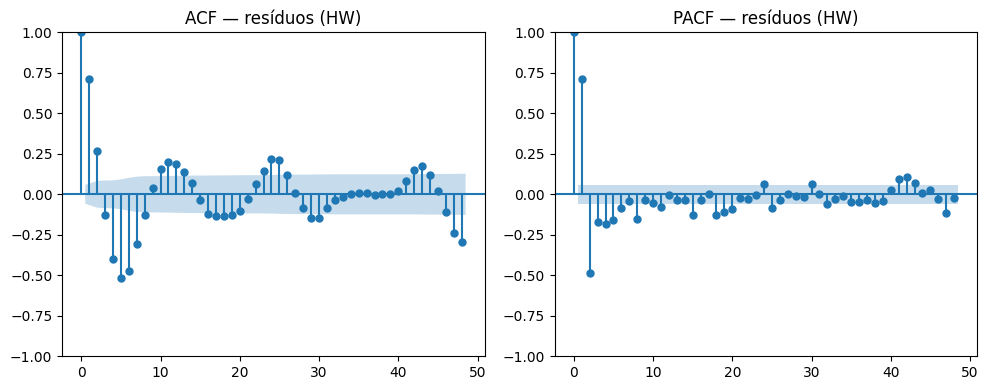

Ljung-Box — resíduos (Holt-Winters):
         lb_stat  lb_pvalue
12  1656.542844        0.0
24  1863.185315        0.0
36  1999.536265        0.0


In [29]:
# =============================================
# 🌤️ Holt–Winters (Exponential Smoothing)
# =============================================

# 3) Ajuste do modelo Holt–Winters (Aditivo no log)
hw_model = ExponentialSmoothing(
    y_log_tr,
    trend=None,             
    seasonal="add", 
    seasonal_periods=24
).fit(optimized=True, use_brute=True)

print(f"AIC={hw_model.aic:.2f} | BIC={hw_model.bic:.2f}")

# 4) Previsão no domínio log
fc_hw_log = hw_model.forecast(len(y_log_te))
fc_hw_log = pd.Series(fc_hw_log, index=y_log_te.index)

# 5) Volta para a escala original
fc_hw = np.expm1(fc_hw_log)

# 6) Avaliação na escala original
m_hw = eval_report(y_test, fc_hw, "Holt-Winters (log)")

# 7) Plot comparativo
plt.figure(figsize=(12,4))
plt.plot(y, label="Real", lw=1)
plt.plot(fc_hw, label="Previsto Holt-Winters", lw=2, alpha=0.85)
plt.axvline(fc_hw.index[0], color="k", ls="--", lw=1, alpha=0.5)
plt.title("Previsão na escala original — Holt-Winters com log(y)")
plt.legend(); plt.tight_layout(); plt.show()

# 8) Resíduos (em log)
resid_hw = y_log_tr - hw_model.fittedvalues
fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(resid_hw.dropna(), lags=48, ax=ax[0]); ax[0].set_title("ACF — resíduos (HW)")
plot_pacf(resid_hw.dropna(), lags=48, ax=ax[1]); ax[1].set_title("PACF — resíduos (HW)")
plt.tight_layout(); plt.show()

# 9) Teste de Ljung–Box
lb_hw = acorr_ljungbox(resid_hw.dropna(), lags=[12,24,36], return_df=True)
print("Ljung-Box — resíduos (Holt-Winters):\n", lb_hw)

# 10) Armazenar resultados para tabela comparativa
comp_hw = {
    "Modelo": "Holt-Winters (log)",
    "AIC": hw_model.aic,
    "BIC": hw_model.bic,
    **m_hw
}


tmp                       MAE=49.238  RMSE=67.795  MAPE=23.14%  R2=0.591
tmp                       MAE=44.012  RMSE=60.803  MAPE=23.46%  R2=0.671
tmp                       MAE=21.619  RMSE=32.834  MAPE=13.68%  R2=0.904
tmp                       MAE=26.899  RMSE=37.300  MAPE=15.45%  R2=0.876


,Modelo,AIC,BIC,MAE,RMSE,MAPE,R2
0,"ARIMA (2, 0, 2) — log ∘ Δ24 ∘ Δ1",-2910.81,-2880.73,49.24,67.79,23.14%,0.59
1,"ARIMA (2, 0, 1) — log ∘ Δ24",-2927.09,-2902.01,44.01,60.80,23.46%,0.67
2,"SARIMA (2,0,2)x(1,1,1,24) — log(y)",-3416.29,-3381.39,21.62,32.83,13.68%,0.90
3,Holt-Winters (log),-5183.25,-5052.42,26.90,37.30,15.45%,0.88


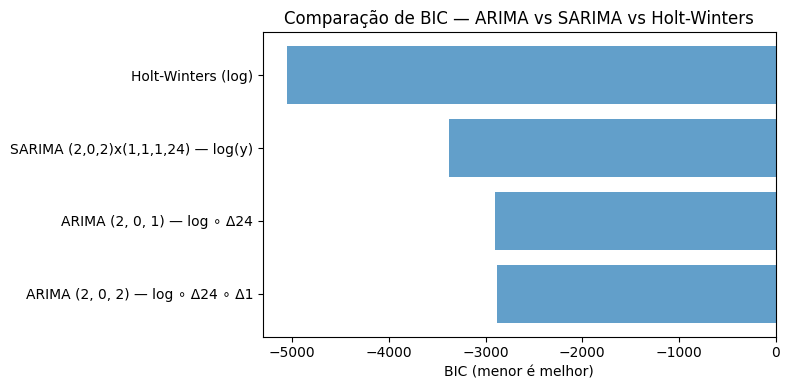

In [30]:
# =========================
# Tabela comparativa final
# =========================

# 1) Alvos alinhados a cada previsão
y_true_baseline = y.loc[yhat_bas.index]
y_true_final    = y.loc[yhat.index]
y_true_sarima   = y_test                 # SARIMA/HW foram feitos com y_train/y_test
y_true_hw       = y_test

# 2) Linhas individuais (sem sobrescrever variáveis)
comp_bas = {
    "Modelo": f"ARIMA {order_baseline} — log ∘ Δ24 ∘ Δ1",
    "AIC": m_bas.aic, "BIC": m_bas.bic,
    **eval_report(y_true_baseline, yhat_bas, "tmp")
}

comp_fin = {
    "Modelo": f"ARIMA {order_best} — log ∘ Δ24",
    "AIC": m_final.aic, "BIC": m_final.bic,
    **eval_report(y_true_final, yhat, "tmp")
}

comp_sar = {
    "Modelo": "SARIMA (2,0,2)x(1,1,1,24) — log(y)",
    "AIC": sarima.aic, "BIC": sarima.bic,
    **eval_report(y_true_sarima, fc_sarima, "tmp")
}

comp_hw = {
    "Modelo": "Holt-Winters (log)",
    "AIC": hw_model.aic, "BIC": hw_model.bic,
    **eval_report(y_true_hw, fc_hw, "tmp")
}

# 3) Constrói a tabela do zero para evitar duplicações
comparacao = pd.DataFrame([comp_bas, comp_fin, comp_sar, comp_hw])

# 4) Ordena/Exibe
cols = ["Modelo","AIC","BIC","MAE","RMSE","MAPE","R2"]
comparacao = comparacao[cols]

display(
    comparacao.style.format({
        "AIC":"{:.2f}","BIC":"{:.2f}","MAE":"{:.2f}","RMSE":"{:.2f}","MAPE":"{:.2f}%",
        "R2":"{:.2f}"
    }).background_gradient(subset=["BIC","RMSE","MAE"], cmap="Blues_r")
)

# 5) Gráfico auxiliar de BIC
plt.figure(figsize=(8,4))
plt.barh(comparacao["Modelo"], comparacao["BIC"], alpha=0.7)
plt.title("Comparação de BIC — ARIMA vs SARIMA vs Holt-Winters")
plt.xlabel("BIC (menor é melhor)")
plt.tight_layout(); plt.show()



## 📈 Comparação no conjunto de teste


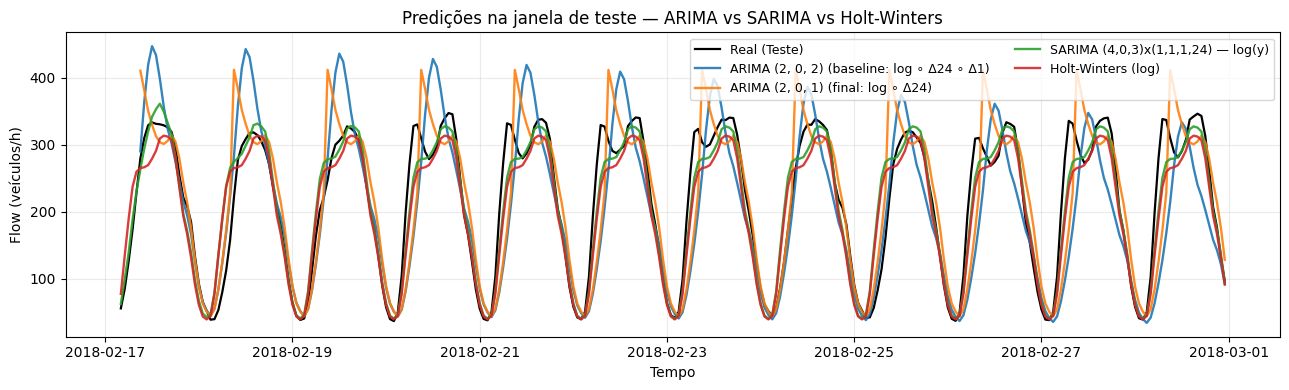

In [31]:
# ==========================================
# 📈 Predições na janela de TESTE — todos os modelos
# ==========================================

# 1) Coletar previsões (certifique-se de já tê-las calculado):
preds_raw = {
    f"ARIMA {order_baseline} (baseline: log ∘ Δ24 ∘ Δ1)": yhat_bas,
    f"ARIMA {order_best} (final: log ∘ Δ24)":             yhat,
    "SARIMA (4,0,3)x(1,1,1,24) — log(y)":                 fc_sarima,
    "Holt-Winters (log)":                        fc_hw,
}

# 2) Alinhar todas as previsões ao índice de teste
preds = {name: s.reindex(y_test.index) for name, s in preds_raw.items()}

# 3) Plot único — série real (teste) + todas as curvas previstas
plt.figure(figsize=(13,4))
plt.plot(y_test, label="Real (Teste)", lw=1.6, color="black")

for name, s in preds.items():
    if s.notna().sum() == 0:
        continue  # nada a plotar
    plt.plot(s, label=name, lw=1.7, alpha=0.9)

plt.title("Predições na janela de teste — ARIMA vs SARIMA vs Holt-Winters")
plt.xlabel("Tempo"); plt.ylabel("Flow (veículos/h)")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


## 🧾 Conclusões e Discussão dos Resultados

A comparação entre os modelos **ARIMA**, **SARIMA** e **Holt–Winters** evidenciou comportamentos distintos em termos de ajuste e capacidade preditiva.  

De forma geral, todos os modelos conseguiram capturar a **sazonalidade diária do tráfego veicular**, refletida nos ciclos regulares de 24 horas observados na série. No entanto, diferenças relevantes emergem ao analisar as métricas quantitativas e os critérios de informação.

### 🔹 Desempenho preditivo
| Modelo | Transformação | MAE | RMSE | MAPE | R² |
|:--|:--|:--|:--|:--|:--|
| ARIMA(2,0,2) | log ∘ Δ24 ∘ Δ1 | 49.24 | 67.79 | 23.14% | 0.59 |
| ARIMA(2,0,1) | log ∘ Δ24 | 44.01 | 60.80 | 23.46% | 0.67 |
| SARIMA(2,0,2)×(1,1,1,24) | log(y) | 21.62 | 32.83 | 13.68% | 0.90 |
| Holt–Winters | log | 26.90 | 37.30 | 15.45% | 0.88 |

Os modelos **ARIMA simples** apresentaram desempenho modesto, com erro médio absoluto (MAE) entre 44 e 49 veículos/h e coeficientes de determinação (R²) inferiores a 0.70.  
A inclusão explícita da **sazonalidade** via **SARIMA** resultou em uma redução substancial dos erros (MAE ≈ 21, RMSE ≈ 33) e em um aumento expressivo de explicabilidade (R² = 0.90).  
O **Holt–Winters**, embora levemente inferior ao SARIMA, também obteve bom desempenho (R² = 0.88), destacando-se pela suavidade e estabilidade das previsões.

### 🔹 Critérios de informação
Em termos de parcimônia, o **Holt–Winters apresentou o menor BIC (-5052)**, seguido pelo SARIMA (-3381), o que indica melhor equilíbrio entre ajuste e complexidade.  
Os modelos ARIMA, apesar de mais simples, apresentaram valores de BIC mais altos (em módulo), refletindo ajuste menos eficiente à estrutura sazonal.

### 🔹 Análise visual
O gráfico de comparação mostra que os modelos **SARIMA e Holt–Winters** acompanham de forma mais fiel os picos e vales do tráfego diário, preservando a amplitude e fase das oscilações.  
Já os **ARIMA sem componente sazonal** tendem a **subestimar os picos** e **suavizar excessivamente os ciclos**, perdendo precisão nos horários de maior fluxo.

---

### ✅ Síntese final
- A transformação **logarítmica** contribuiu para estabilizar a variância da série.  
- A diferenciação sazonal de 24h foi eficaz para os modelos ARIMA, mas redundante para o SARIMA.  
- O **SARIMA(2,0,2)×(1,1,1,24)** apresentou o melhor equilíbrio entre desempenho e explicabilidade.  
- O **Holt–Winters** surge como alternativa competitiva, simples e robusta, especialmente em contextos de previsão operacional de curto prazo.  

➡️ **Conclusão:**  
Para o conjunto PEMS04, o modelo **SARIMA(2,0,2)×(1,1,1,24)** sobre a série log-transformada oferece a melhor previsão do fluxo de veículos, conciliando baixo erro, alto R² e fidelidade à sazonalidade diária observada.
